# DINO Logit Lens: Analyzing Representations in ViT Models

In this notebook, we transfer the concept of the logit lens from language models (like GPT) to computer vision models — specifically to the self-supervised DINO model with Vision Transformers (ViT).

Objectives:
- Inspect how the [CLS] token representation evolves across layers.
- Compare intermediate representations with the final one.
- Measure similarity (e.g., cosine similarity) between intermediate and final predictions.
- Generate plots for ViT-S/16 and ViT-B/8 models (trained with DINO).

Method: extract the representation at a chosen layer, pass it through the remaining layers, and compare the output to the full forward pass result.

Model: [DINO repository](https://github.com/facebookresearch/dino)

In [ ]:
# !pip install torch torchvision timm matplotlib seaborn

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.models as models

from PIL import Image
import timm

import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

c:\Users\olenk\PWProjects\WB_2_Project\VisualLogitLens\dino_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def extract_layer_outputs(model, x):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks = [blk.register_forward_hook(hook_fn) for blk in model.blocks]

    with torch.no_grad():
        _ = model(x)

    for hook in hooks:
        hook.remove()

    return activations

def compute_logits_from_layers(model, layer_outputs):
    cls_tokens = [output[:, 0] for output in layer_outputs]  # CLS token
    head = model.head
    logits = [head(cls) for cls in cls_tokens]
    return logits

def compute_cosine_similarities(logits):
    final_logit = logits[-1]
    similarities = [
        F.cosine_similarity(logit, final_logit).item() for logit in logits
    ]
    return similarities

def plot_similarities(*similarity_label_pairs):
    plt.figure(figsize=(10, 6))

    for sim_scores, label in similarity_label_pairs:
        plt.plot(range(1, len(sim_scores)+1), sim_scores, marker='o', label=label)

    plt.xlabel("Transformer Layer")
    plt.ylabel("Cosine Similarity to Final Logits")
    plt.title("Logit Lens on DINO and XCiT Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_xcit_main
c:\Users\olenk\PWProjects\WB_2_Project\VisualLogitLens\dino_env\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\olenk\PWProjects\WB_2_Project\VisualLogitLens\dino_env\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in C:\Users\olenk/.cache\torch\hub

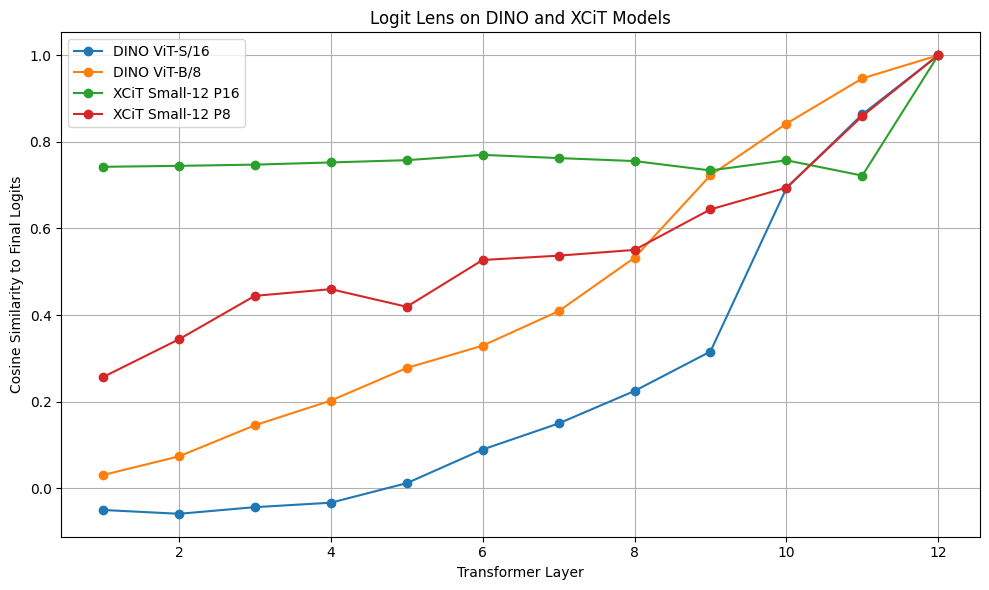

In [ ]:
img_tensor = load_image('../photos/flower.jpg')

# Load models
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
vitb8 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')
xcit_small_12_p16 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_small_12_p16')
xcit_small_12_p8 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_small_12_p8')


vits16.eval()
vitb8.eval()
xcit_small_12_p16.eval()
xcit_small_12_p8.eval()

# Extract and compare logits
outputs_s16 = extract_layer_outputs(vits16, img_tensor)
logits_s16 = compute_logits_from_layers(vits16, outputs_s16)
sims_s16 = compute_cosine_similarities(logits_s16)

outputs_b8 = extract_layer_outputs(vitb8, img_tensor)
logits_b8 = compute_logits_from_layers(vitb8, outputs_b8)
sims_b8 = compute_cosine_similarities(logits_b8)

outputs_12_p16 = extract_layer_outputs(xcit_small_12_p16, img_tensor)
logits_12_p16 = compute_logits_from_layers(xcit_small_12_p16, outputs_12_p16)
sims_12_p16 = compute_cosine_similarities(logits_12_p16)

outputs_12_p8 = extract_layer_outputs(xcit_small_12_p8, img_tensor)
logits_12_p8 = compute_logits_from_layers(xcit_small_12_p8, outputs_12_p8)
sims_12_p8 = compute_cosine_similarities(logits_12_p8)



plot_similarities(
    (sims_s16, "DINO ViT-S/16"),
    (sims_b8, "DINO ViT-B/8"),
    (sims_12_p16, "XCiT Small-12 P16"),
    (sims_12_p8, "XCiT Small-12 P8"),
)


The visualization above illustrates that the XCiT Small-12 P16 model consistently maintains a high cosine similarity to the final CLS token representation from the very first layers, reaching values around 0.8. In contrast, the XCiT Small-12 P8 and DINO ViT-B/8 models gradually improve their alignment as depth increases. Notably, the DINO ViT-S/16 model starts with the lowest similarity scores but exhibits a sharp increase in the final layers, indicating a late consolidation of semantic information.

In [15]:
def load_images_from_folder(folder_path):
    transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225)),
    ])
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images = []
    image_names = []
    for file in image_files:
        try:
            img_path = os.path.join(folder_path, file)
            image = Image.open(img_path).convert("RGB")
            images.append(transform(image))
            image_names.append(file)
        except Exception as e:
            print(f"Error loading image {file}: {e}")
    return torch.stack(images), image_names  # (B, 3, 224, 224), [names]


def compute_logit_lens_similarities(model, inputs):
    with torch.no_grad():
        x = model.patch_embed(inputs)
        B, N, D = x.shape
        cls_token = model.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + model.pos_embed
        x = model.pos_drop(x)

        all_cls_reps = []

        for blk in model.blocks:
            x = blk(x)
            cls = model.norm(x)[:, 0]
            all_cls_reps.append(cls)

        final_cls = all_cls_reps[-1]

        similarities = []
        for cls in all_cls_reps:
            sim = F.cosine_similarity(cls, final_cls, dim=-1)
            similarities.append(sim.cpu().numpy())

        return np.stack(similarities, axis=1)  # shape: (B, num_layers)


def plot_similarity_heatmap(similarities, image_labels=None):
    num_images, num_layers = similarities.shape
    if image_labels is None:
        image_labels = [f"Image {i+1}" for i in range(num_images)]

    plt.figure(figsize=(14, 5))
    sns.heatmap(
        similarities,
        annot=True,
        cmap='viridis',
        xticklabels=range(num_layers),
        yticklabels=image_labels,
        cbar_kws={'label': 'Cosine similarity to final CLS token'}
    )
    plt.xlabel('Layer')
    plt.ylabel('Input')
    plt.title('Similarity of CLS token to final layer')
    plt.tight_layout()
    plt.show()

Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main



----- DINO ViT-S/16 -----


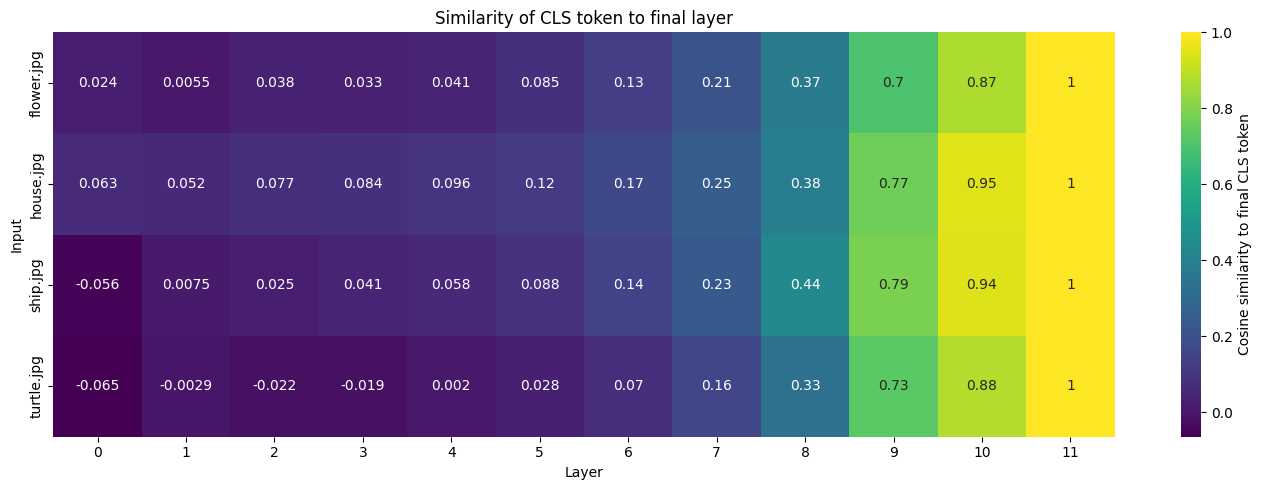


----- DINO ViT-B/8 -----


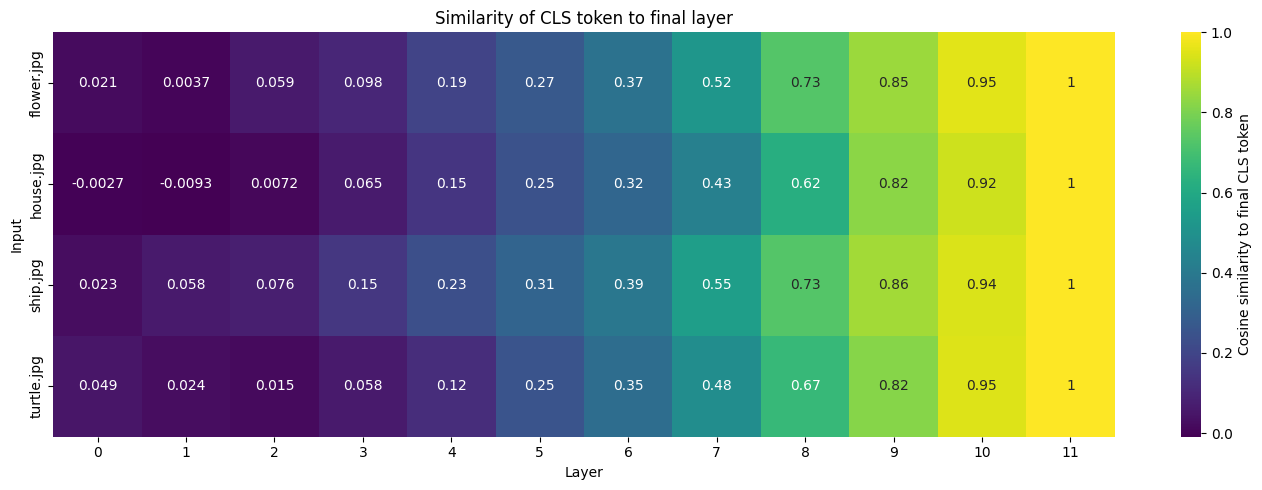

In [17]:
models = {
        "DINO ViT-S/16": torch.hub.load('facebookresearch/dino:main', 'dino_vits16'),
        "DINO ViT-B/8": torch.hub.load('facebookresearch/dino:main', 'dino_vitb8'),
    }

for model in models.values():
        model.eval()

folder_path = "../photos"
inputs, image_names = load_images_from_folder(folder_path)

for model_name, model in models.items():
        print(f"\n----- {model_name} -----")
        similarities = compute_logit_lens_similarities(model, inputs)
        plot_similarity_heatmap(similarities, image_labels=image_names)
